In [1]:
%reset -f
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
from torch import device as torch_device

#devices = [torch_device('cuda', i) for i in range(torch.cuda.device_count())] + [torch_device('cpu')]
#print(devices)
desired_gpu_index = 0
device = torch.device(f'cuda:{desired_gpu_index}')
device

__Python VERSION: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
__pyTorch VERSION: 2.0.1
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 2
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA A100-PCIE-40GB, 525.125.06, 40960 MiB, 0 MiB, 40336 MiB
1, NVIDIA A100 80GB PCIe, 525.125.06, 81920 MiB, 77570 MiB, 3481 MiB
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


device(type='cuda', index=0)

In [2]:
import os
from unet_parts import *
from unet_parts_att_transformer import *
from unet_parts_att_multiscale import *
from transformerskip import tskip
import random
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)
device

device(type='cuda', index=0)

In [3]:
torch.cuda.device_count()

2

In [4]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage
from torchsummary import summary

In [5]:
from torchmetrics import Dice
import torch.optim as optim

In [6]:
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
def dice_loss(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_coeff(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


# def dice_loss(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1 - dice
# def dice_coeff(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return dice

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary




In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# Define custom dataset class

def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    img = img.astype(np.float32)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    #print(np.amax(img),np.amin(img))
    img = ToTensor()(img)
    #img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = img_path[:-4] + '_mask.png'
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,image_size, interpolation = cv2.INTER_NEAREST)
    #mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    mask = torch.from_numpy(mask).long()
    return mask

class DataGen(Dataset):
    def __init__(self, image_size, images_path , transform=None):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image = parse_image(self.images_path[index], self.image_size)
        mask = parse_mask(self.images_path[index], self.image_size)

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [9]:
paths = glob.glob("/home/rabeea/bul/*/**.png", recursive = True)
imgpath = []
for path in paths:
    if not 'mask' in path:
        imgpath.append(path)
print(len(imgpath))

647


In [10]:
tr = 400
val = 120
ts = 160
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
imgpath[0][:-4] + '_mask.png'

647 400 120 127


'/home/rabeea/bul/benign/benign (218)_mask.png'

In [11]:
image_size = (256,256)
batch_size = 1

epochs = 100

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath)
val_gen = DataGen(image_size,valpath)
test_gen = DataGen(image_size,testpath)

train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_gen, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_gen, batch_size=1, shuffle=False) 

Feature batch shape: torch.Size([1, 1, 256, 256])
Labels batch shape: torch.Size([1, 256, 256])


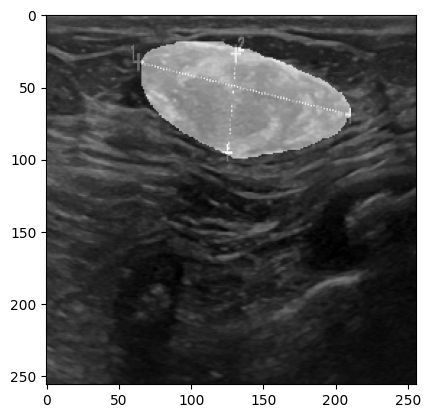

In [12]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.imshow(label, 'gray', alpha=0.5)

In [13]:
np.unique(label)

array([0, 1])

In [14]:
img.dtype

torch.float32

In [15]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(1024, 256 // factor, bilinear)
        self.up3 = Up(512, 128 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)


        '''位置编码'''
        self.pos = PositionEmbeddingLearned(512 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(512)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(512)

        '''残差多尺度连接'''
        self.fuse1 = MultiConv(768, 256)
        self.fuse2 = MultiConv(384, 128)
        self.fuse3 = MultiConv(192, 64)
        self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        
        
        '''Setting 1'''
        x5_pam = self.pam(x5)

        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        

        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [16]:
model = UNet_Attention_Transformer_Multiscale()

In [17]:
model

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

In [18]:
model.to(device)

# # Define an example input size
# input_size = (1, 256, 256)

# # Create an example input tensor
# input_tensor = torch.randn(input_size).to(device)

# # Print the model summary
# summary(model, input_size=input_size)

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 25964618


In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 25964618


In [19]:
epochs = 200

In [19]:
filename_sd = '/home/rabeea/logs/TransAttUnetSkip/Simple_layers5_f64_b1.pth'

In [21]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)#, momentum=0.9)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
fit_time = time.time()
not_improve=0
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = data
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_targets).item()
            test_loss += dice_loss(val_outputs,val_targets).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        torch.save(model.state_dict(), filename_sd)
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.000 >> 0.191 
saving model...
Epoch 1/200, Train Loss: 0.8076, Train Dice: 0.1924, Val Dice: 0.1906, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.191 >> 0.230 
saving model...
Epoch 2/200, Train Loss: 0.7405, Train Dice: 0.2595, Val Dice: 0.2299, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.230 >> 0.257 
saving model...
Epoch 3/200, Train Loss: 0.6927, Train Dice: 0.3073, Val Dice: 0.2574, time: 0.31


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.6416, Train Dice: 0.3584, Val Dice: 0.2572, time: 0.35


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.5824, Train Dice: 0.4176, Val Dice: 0.2484, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.257 >> 0.286 
saving model...
Epoch 6/200, Train Loss: 0.5111, Train Dice: 0.4889, Val Dice: 0.2860, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.4492, Train Dice: 0.5508, Val Dice: 0.2722, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.4022, Train Dice: 0.5978, Val Dice: 0.2472, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.286 >> 0.315 
saving model...
Epoch 9/200, Train Loss: 0.3521, Train Dice: 0.6479, Val Dice: 0.3148, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.3258, Train Dice: 0.6742, Val Dice: 0.2411, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.315 >> 0.359 
saving model...
Epoch 11/200, Train Loss: 0.2869, Train Dice: 0.7131, Val Dice: 0.3593, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.359 >> 0.391 
saving model...
Epoch 12/200, Train Loss: 0.2486, Train Dice: 0.7514, Val Dice: 0.3908, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13/200, Train Loss: 0.2160, Train Dice: 0.7840, Val Dice: 0.3703, time: 0.32


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14/200, Train Loss: 0.1963, Train Dice: 0.8037, Val Dice: 0.3223, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15/200, Train Loss: 0.1746, Train Dice: 0.8254, Val Dice: 0.3728, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16/200, Train Loss: 0.1677, Train Dice: 0.8323, Val Dice: 0.3742, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17/200, Train Loss: 0.1525, Train Dice: 0.8475, Val Dice: 0.3679, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18/200, Train Loss: 0.1352, Train Dice: 0.8648, Val Dice: 0.3209, time: 0.30


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19/200, Train Loss: 0.1269, Train Dice: 0.8731, Val Dice: 0.3243, time: 0.32


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20/200, Train Loss: 0.1285, Train Dice: 0.8715, Val Dice: 0.3618, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.391 >> 0.409 
saving model...
Epoch 21/200, Train Loss: 0.1104, Train Dice: 0.8896, Val Dice: 0.4091, time: 0.44


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22/200, Train Loss: 0.0999, Train Dice: 0.9001, Val Dice: 0.3364, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23/200, Train Loss: 0.0969, Train Dice: 0.9031, Val Dice: 0.3965, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24/200, Train Loss: 0.0937, Train Dice: 0.9063, Val Dice: 0.3674, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25/200, Train Loss: 0.1032, Train Dice: 0.8968, Val Dice: 0.3429, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26/200, Train Loss: 0.0869, Train Dice: 0.9131, Val Dice: 0.4032, time: 0.48


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27/200, Train Loss: 0.0784, Train Dice: 0.9216, Val Dice: 0.3857, time: 0.42


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.409 >> 0.424 
saving model...
Epoch 28/200, Train Loss: 0.0732, Train Dice: 0.9268, Val Dice: 0.4239, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 29/200, Train Loss: 0.0702, Train Dice: 0.9298, Val Dice: 0.4089, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 30/200, Train Loss: 0.0697, Train Dice: 0.9303, Val Dice: 0.2885, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 31/200, Train Loss: 0.0780, Train Dice: 0.9220, Val Dice: 0.3961, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.424 >> 0.425 
saving model...
Epoch 32/200, Train Loss: 0.0655, Train Dice: 0.9345, Val Dice: 0.4250, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.425 >> 0.431 
saving model...
Epoch 33/200, Train Loss: 0.0590, Train Dice: 0.9410, Val Dice: 0.4312, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 34/200, Train Loss: 0.0567, Train Dice: 0.9433, Val Dice: 0.4226, time: 0.42


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 35/200, Train Loss: 0.0545, Train Dice: 0.9455, Val Dice: 0.4104, time: 0.43


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 36/200, Train Loss: 0.0523, Train Dice: 0.9477, Val Dice: 0.4228, time: 0.42


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.431 >> 0.438 
saving model...
Epoch 37/200, Train Loss: 0.0507, Train Dice: 0.9493, Val Dice: 0.4378, time: 0.49


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 38/200, Train Loss: 0.0488, Train Dice: 0.9512, Val Dice: 0.4276, time: 0.47


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 39/200, Train Loss: 0.0495, Train Dice: 0.9505, Val Dice: 0.4328, time: 0.42


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 40/200, Train Loss: 0.0474, Train Dice: 0.9526, Val Dice: 0.4159, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 41/200, Train Loss: 0.0458, Train Dice: 0.9542, Val Dice: 0.4377, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 42/200, Train Loss: 0.0437, Train Dice: 0.9563, Val Dice: 0.4234, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 43/200, Train Loss: 0.0426, Train Dice: 0.9574, Val Dice: 0.4188, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 44/200, Train Loss: 0.0416, Train Dice: 0.9584, Val Dice: 0.4229, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 66/200, Train Loss: 0.0287, Train Dice: 0.9713, Val Dice: 0.4594, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 67/200, Train Loss: 0.0283, Train Dice: 0.9717, Val Dice: 0.4392, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 68/200, Train Loss: 0.0280, Train Dice: 0.9720, Val Dice: 0.4671, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 69/200, Train Loss: 0.0277, Train Dice: 0.9723, Val Dice: 0.4464, time: 0.25


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 70/200, Train Loss: 0.0267, Train Dice: 0.9733, Val Dice: 0.4554, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 71/200, Train Loss: 0.0269, Train Dice: 0.9731, Val Dice: 0.4568, time: 0.28


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 72/200, Train Loss: 0.0266, Train Dice: 0.9734, Val Dice: 0.4632, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Dice increasing.. 0.470 >> 0.475 
saving model...
Epoch 73/200, Train Loss: 0.0263, Train Dice: 0.9737, Val Dice: 0.4746, time: 0.28


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 74/200, Train Loss: 0.0257, Train Dice: 0.9743, Val Dice: 0.4381, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 75/200, Train Loss: 0.0254, Train Dice: 0.9746, Val Dice: 0.4711, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 97/200, Train Loss: 0.0205, Train Dice: 0.9795, Val Dice: 0.4857, time: 0.43


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 98/200, Train Loss: 0.0205, Train Dice: 0.9795, Val Dice: 0.4577, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 99/200, Train Loss: 0.0204, Train Dice: 0.9796, Val Dice: 0.4918, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 100/200, Train Loss: 0.0204, Train Dice: 0.9796, Val Dice: 0.4807, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 101/200, Train Loss: 0.0199, Train Dice: 0.9801, Val Dice: 0.4764, time: 0.40


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 102/200, Train Loss: 0.0199, Train Dice: 0.9801, Val Dice: 0.4755, time: 0.43


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 103/200, Train Loss: 0.0197, Train Dice: 0.9803, Val Dice: 0.4944, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 104/200, Train Loss: 0.0192, Train Dice: 0.9808, Val Dice: 0.4764, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 125/200, Train Loss: 0.0163, Train Dice: 0.9837, Val Dice: 0.4976, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 126/200, Train Loss: 0.0165, Train Dice: 0.9835, Val Dice: 0.5095, time: 0.41


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 127/200, Train Loss: 0.0162, Train Dice: 0.9838, Val Dice: 0.5051, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 128/200, Train Loss: 0.0162, Train Dice: 0.9838, Val Dice: 0.4952, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 129/200, Train Loss: 0.0163, Train Dice: 0.9837, Val Dice: 0.4951, time: 0.38


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 130/200, Train Loss: 0.0158, Train Dice: 0.9842, Val Dice: 0.4976, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 131/200, Train Loss: 0.0154, Train Dice: 0.9846, Val Dice: 0.5087, time: 0.38


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 132/200, Train Loss: 0.0154, Train Dice: 0.9846, Val Dice: 0.4905, time: 0.45


  0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 155/200, Train Loss: 0.0136, Train Dice: 0.9864, Val Dice: 0.5153, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 156/200, Train Loss: 0.0133, Train Dice: 0.9867, Val Dice: 0.5176, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 157/200, Train Loss: 0.0138, Train Dice: 0.9862, Val Dice: 0.5080, time: 0.28


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 158/200, Train Loss: 0.0136, Train Dice: 0.9864, Val Dice: 0.5121, time: 0.28


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 159/200, Train Loss: 0.0138, Train Dice: 0.9862, Val Dice: 0.5124, time: 0.39


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 160/200, Train Loss: 0.0132, Train Dice: 0.9868, Val Dice: 0.5179, time: 0.34


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 161/200, Train Loss: 0.0131, Train Dice: 0.9869, Val Dice: 0.5055, time: 0.26


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 162/200, Train Loss: 0.0131, Train Dice: 0.9869, Val Dice: 0.5134, time: 0.28


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 163/200, Train Loss: 0.0131, Train Dice: 0.9869, Val Dice: 0.5090, time: 0.27


  0%|          | 0/400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [23]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.987419144064188
max validation dice:  0.5230355238102978


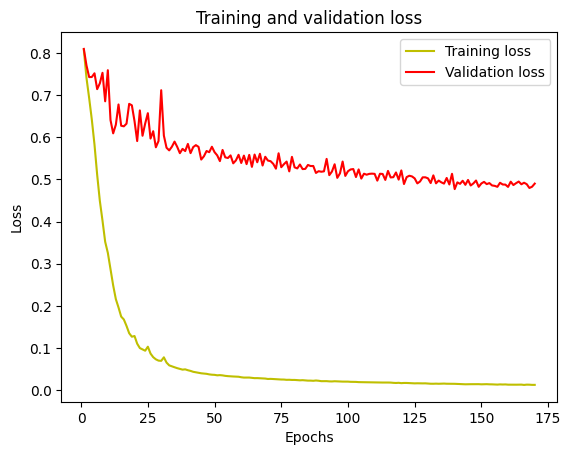

In [24]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

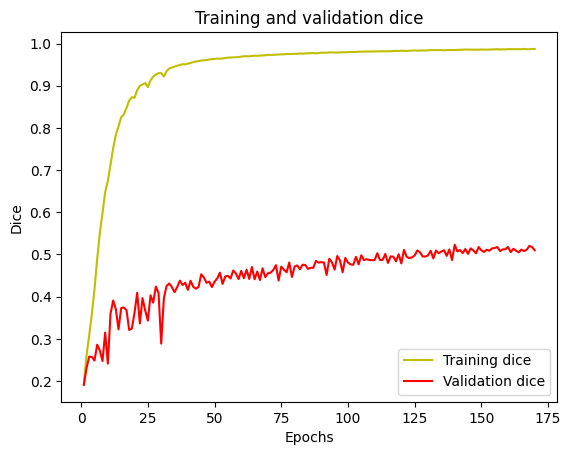

In [25]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [20]:
model.load_state_dict(torch.load(filename_sd, map_location=device))

<All keys matched successfully>

In [22]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
        test_dice005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
        test_dice001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
        test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
        test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))

  0%|          | 0/127 [00:00<?, ?it/s]

Test dice at 0.9:  0.5632639612072304
Test dice at 0.8:  0.5706667404493909
Test dice at 0.7:  0.5751940807596954
Test dice at 0.6:  0.5781507774541593
Test dice at 0.5:  0.5801190589500468
Test dice at 0.4:  0.582204276188106
Test dice at 0.3:  0.5840090399484669
Test dice at 0.2:  0.5857447876263417
Test dice at 0.1:  0.5888180983234548
Test dice at 0.05:  0.5911993775321672
Test dice at 0.01:  0.5941555254356949
Test dice at 0.005:  0.5940317108013872
Test dice at 0.001:  0.5870591383064157
Test dice at 0.0005:  0.5781383687008345
Test dice at 0.0001:  0.4615809339736625


# filename_sd = '/home/rabeea/logs/TransAttUnetSkip/Simple_layers5_f64.pth'

In [25]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.9662478703260422
max validation dice:  0.5737557266023942


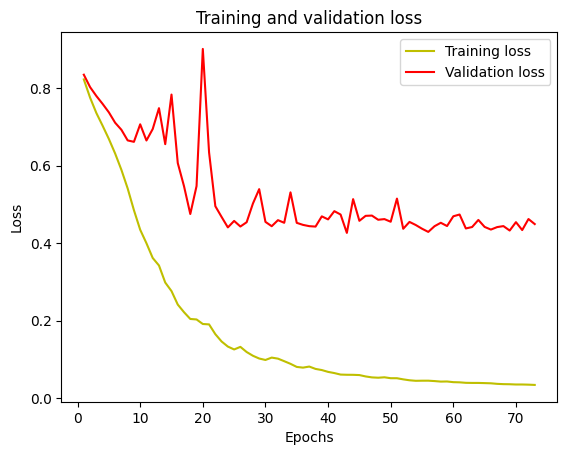

In [26]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

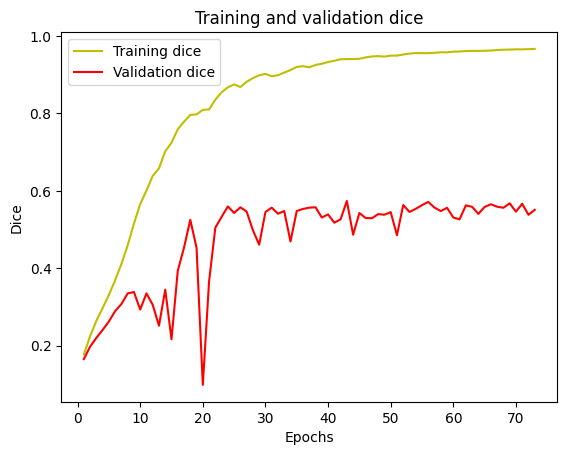

In [27]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [28]:
model.load_state_dict(torch.load(filename_sd))#, map_location=device))

<All keys matched successfully>

In [29]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/127 [00:00<?, ?it/s]

Test dice at 0.9:  0.620697150047796
Test dice at 0.8:  0.616999520902686
Test dice at 0.7:  0.6135111416557824
Test dice at 0.6:  0.6106610954412595
Test dice at 0.5:  0.607635056483101
Test dice at 0.4:  0.6039204367348355
Test dice at 0.3:  0.5997717953212587
Test dice at 0.2:  0.5940788685747832
Test dice at 0.1:  0.5837301572842187
Test dice at 0.05:  0.5728028779078274
Test dice at 0.01:  0.5349939240045996


# TransAttUnetSkip/TransAttUNet_new.pth

In [22]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.9803039494156838
max validation dice:  0.5844470958909369


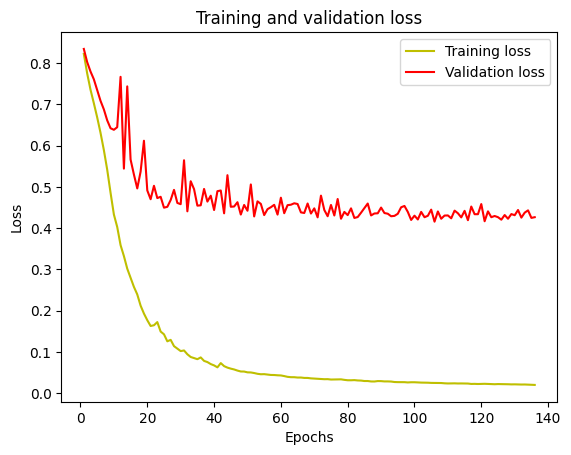

In [23]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

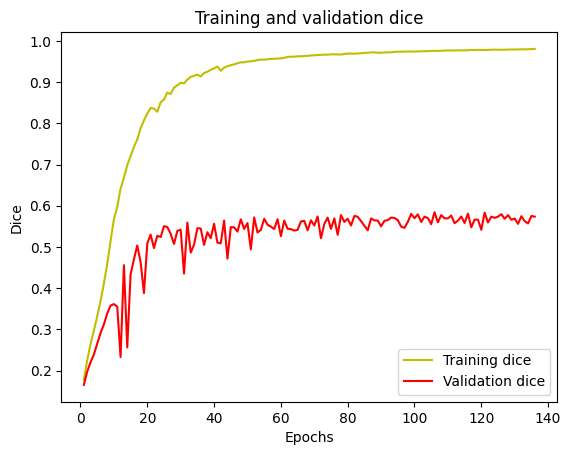

In [24]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [19]:
model.load_state_dict(torch.load('/home/rabeea/logs/TransAttUnetSkip/TransAttUNet_new.pth', map_location=device))

<All keys matched successfully>

In [20]:
num_batches = 1
# Validation
model.eval()
print(next(model.parameters()).is_cuda)
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        print(val_inputs.get_device())
        print(val_targets.get_device())
        val_outputs = model(val_inputs)
        print(val_outputs.get_device())
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        print(test_outputs.get_device())
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

True


  0%|          | 0/127 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [20]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.9600309937000274
max validation dice:  0.5896087081365597


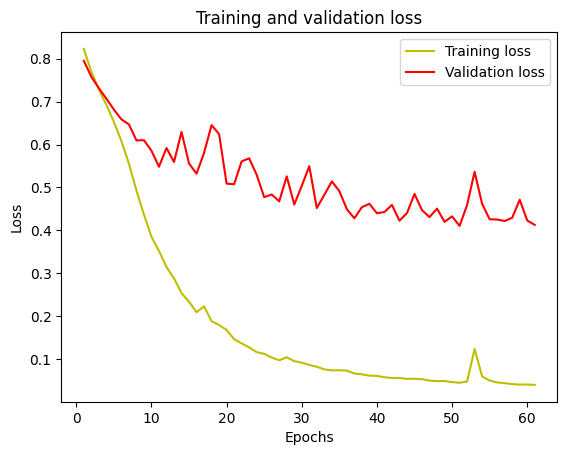

In [21]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

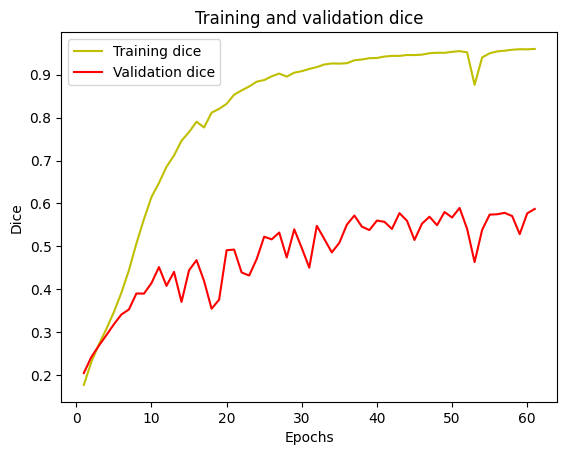

In [22]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [23]:
torch.save(model, '/home/rabeea/logs/TransAttUnetSkip/TransAttUNet_lastepoch.pt')
torch.save(model.state_dict(), '/home/rabeea/logs/TransAttUnetSkip/TransAttUNet_lastepoch.pth')

In [24]:
model.load_state_dict(torch.load('/home/rabeea/logs/TransAttUnetSkip/TransAttUNetSkip.pth'))

<All keys matched successfully>

In [25]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))

  0%|          | 0/27 [00:00<?, ?it/s]

Test dice at 0.9:  0.3593524845316467
Test dice at 0.8:  0.3773019775401702
Test dice at 0.7:  0.38667471175857054
Test dice at 0.6:  0.39403151992936963
Test dice at 0.5:  0.40118691414331636
Test dice at 0.4:  0.408748619429793
Test dice at 0.3:  0.4166764770009279
Test dice at 0.2:  0.4275966542287885
Test dice at 0.1:  0.44487521491720583
Test dice at 0.05:  0.46412338990248153
Test dice at 0.01:  0.5122798553687365


In [41]:
model.eval()
with torch.no_grad():
    val_inputs, val_targets = next(iter(train_loader))
    val_inputs = val_inputs.to(device)
    val_targets = val_targets.to(device)
    val_outputs = model(val_inputs)
    loss = dice_loss(val_outputs, val_targets)
    coeff = dice_coeff(val_outputs, val_targets)
    index = val_outputs.cpu().data.numpy()#.argmax()
    indexx = val_targets.cpu().data.numpy()
print(loss,coeff)
print(index,indexx)


tensor(-0.6144, device='cuda:0') tensor(1.6144, device='cuda:0')
[[[[-204.68536 -187.60037 -183.85892 ... -181.43098 -185.72186
    -202.07846]
   [-186.82632 -181.89316 -176.30037 ... -176.32126 -180.62067
    -185.0506 ]
   [-182.74246 -174.45444 -173.81912 ... -173.19324 -172.6259
    -179.19249]
   ...
   [-185.69293 -179.60449 -178.80048 ... -175.33269 -174.82068
    -180.64778]
   [-188.8993  -182.47983 -177.35175 ... -174.03851 -178.13919
    -184.0625 ]
   [-201.42511 -181.91902 -177.50568 ... -173.1037  -177.45773
    -195.74463]]]


 [[[-200.95789 -185.63855 -180.97212 ... -180.69653 -185.9169
    -199.32791]
   [-185.07394 -182.7733  -175.58937 ... -174.43292 -181.51201
    -183.02753]
   [-179.11862 -173.55545 -170.7327  ... -166.69353 -169.54407
    -175.40671]
   ...
   [-179.19908 -170.1925  -167.75494 ... -158.97388 -161.15182
    -172.93604]
   [-183.57135 -175.03687 -168.7973  ... -162.33032 -167.7228
    -178.11588]
   [-197.37714 -177.55461 -173.21176 ... -170.27066

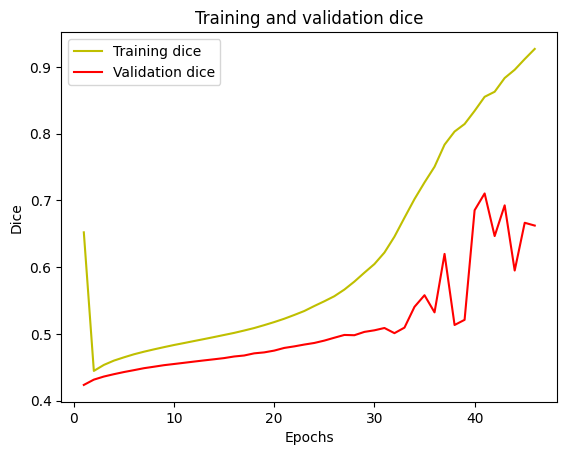

In [24]:
#plot the training and validation IoU and loss at each epoch
loss = train_dices
val_loss = val_dices
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [28]:
val_loss[40]

0.2896213640769323

In [30]:
val_dices

[0.4233641164377332,
 0.43129169043774407,
 0.43592848619446156,
 0.4394563547646006,
 0.44266126717751225,
 0.44549059721951684,
 0.44843592699617146,
 0.4506498610600829,
 0.4529582292151948,
 0.45472586940353116,
 0.4565188185622295,
 0.4583455073957642,
 0.4601143218576908,
 0.4618081575259566,
 0.4635809983126819,
 0.46597531748314697,
 0.46746807160476844,
 0.47069006313880285,
 0.4721317773374418,
 0.4748018581420183,
 0.4788052209032079,
 0.48113187852626044,
 0.48386634411290286,
 0.4862511405410866,
 0.48979133407895764,
 0.49410517755895855,
 0.49826745701332886,
 0.49786705582713087,
 0.5028495284418265,
 0.5052328289796909,
 0.5086974913254381,
 0.5009545868262648,
 0.5092407756174604,
 0.540400409201781,
 0.5578156077613433,
 0.5321075343216459,
 0.6197334619859854,
 0.513205413458248,
 0.5209389263764024,
 0.6852028558651606,
 0.7103786369785666,
 0.6464963380247355,
 0.6925455562149485,
 0.5948248479515315,
 0.6664097834999363,
 0.6622186228632927]

In [29]:
min(val_loss)

0.2896213640769323

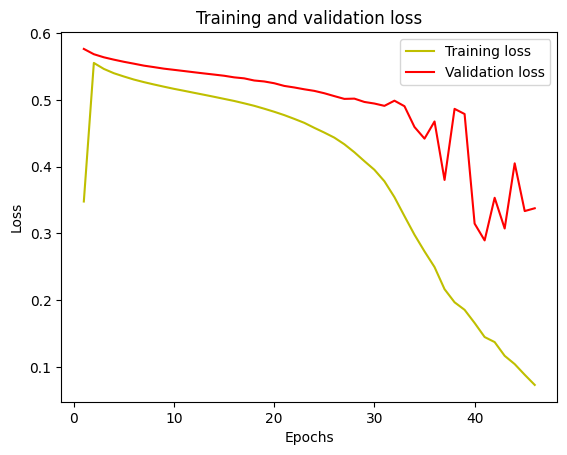

In [27]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
a = torch.rand(2, 500,3,2,4)

In [32]:
torch.flatten(a,1).shape

torch.Size([2, 12000])